# Trabalho Final - Probabilidade

# Docente - Ivanovitch Medeiros

# Discente - Rafael Costa Varela

# Seleção da turma (via Shell Script)

Códigos dos componentes curriculares que tiveram turmas nos períodos 2014.1, 2015.1, e 2016.1 no horário 246N12

cat *csv | grep "246N12" | cut -d \; -f 6 | sort | uniq -c | sort -n -k 1 | head -40 | tail -10

# Disciplina escolhida

FISICA BASICA III (Código: 22930)

# Bibliotecas utilizadas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

# Funções Auxiliares

#### Faz a função map (bultin do Python) retornar listas ao invés de geradores

In [2]:
lmap = lambda f, d: list(map(f, d))

#### Carrega os datasets

In [3]:
def carregar(ano, periodo):
    turmas = pd.read_csv(f'turmas-{ano}.{periodo}.csv', sep=';')
    turmas['id_turma'] = pd.to_numeric(turmas['id_turma'])
    matriculas = pd.read_csv(f'matricula-componente-{ano}{periodo}.csv', sep=';')
    return turmas, matriculas

#### Junta dois datasets com base na coluna id_turma

In [4]:
def juntar(turma, matricula):
    return turma.merge(matricula, how='right', right_on='id_turma', left_on='id_turma')

#### Filtra um dataset com base no código do componente curricular e do horário, ambos especificados anteriormente

In [5]:
def filtrar(dataset):
    return dataset.query(f'id_componente_curricular == {CODIGO_COMPONENTE}').query(f'descricao_horario.str.contains("{HORARIO}")')

#### Faz o encadeamento das funções anteriores e aplica esse encadeamento de uma vez só nos conjuntos de dados

In [6]:
def pipeline_carregamento_dados(ano, periodo):
    turmas, matriculas = carregar(ano, periodo)
    dataset = juntar(turmas, matriculas)
    return filtrar(dataset)

#### Retorna a média de valores de um campo do dataset

In [7]:
def dados_campo(campo, datasets):
    return lmap(lambda dataset: dataset[campo].mean(), datasets)

#### Plota um gráfico de barras

In [8]:
def grafico_barras(dados, titulo):
    sns.set(style="whitegrid")
    labels = PERIODOS
    return sns.barplot(x=labels, y=dados).set_title(titulo)

# Constantes

In [9]:
COMPONENTE_CURRICULAR_NOME = 'FISICA BASICA III'
CODIGO_COMPONENTE = 22930 # Fonte: http://dados.ufrn.br/dataset/componentes-curriculares/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727
HORARIO = "246N12"
PERIODOS = '2014.1,2015.1,2016.1'.split(',')

In [10]:
QTD_DE_AULAS = 'qtd_aulas_lancadas'
MEDIA_FINAL = 'media_final'
NOTA_DA_MEDIA = 'nota'
UNIDADE = 'unidade'

# Datasets

In [11]:
dataset_2014_1 = pipeline_carregamento_dados(2014, 1)
dataset_2015_1 = pipeline_carregamento_dados(2015, 1)
dataset_2016_1 = pipeline_carregamento_dados(2016, 1)

In [12]:
datasets = [dataset_2014_1, dataset_2015_1, dataset_2016_1]

# Quantidade de Aulas

In [13]:
aulas = dados_campo(QTD_DE_AULAS, datasets)

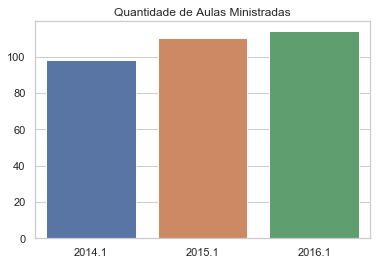

In [14]:
%matplotlib inline
ax = grafico_barras(aulas, 'Quantidade de Aulas Ministradas')
plt.show()

# Médias finais

In [15]:
medias_finais = dados_campo(MEDIA_FINAL, datasets)

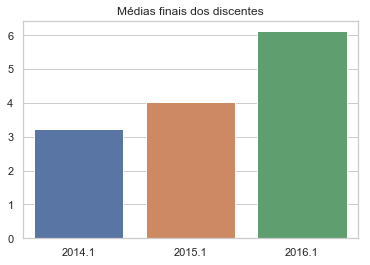

In [16]:
%matplotlib inline
ax = grafico_barras(medias_finais, 'Médias finais dos discentes')
plt.show()

# Médias nas unidades

In [17]:
def medias_unidades(dataset):
    unidades = dataset[dataset[UNIDADE] > 0][UNIDADE].unique()
    medias = lmap(lambda unidade: dataset[dataset[UNIDADE] == unidade][NOTA_DA_MEDIA].mean(), unidades)
    return medias

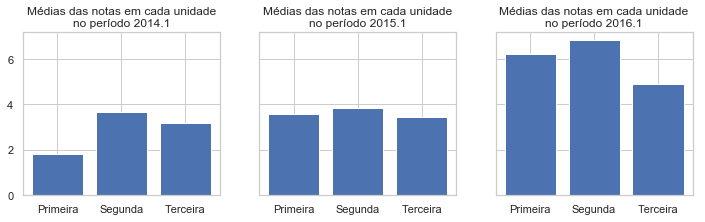

In [18]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True) # Gera 3 slots para colocar os gráficos de cada período
unidades = ['Primeira', 'Segunda', 'Terceira']
for i, ax in enumerate(axs):
    ax.bar(unidades, medias_unidades(datasets[i])) # Plota um gráfico de barras
    ax.set_title(f'Médias das notas em cada unidade\nno período {PERIODOS[i]}')
plt.show()

# Situação dos Discentes

#### Retorna as percentagens de alunos aprovados e reprovados em um determinado período

In [19]:
def situacoes_discentes(dataset):
    reprovados = (dataset.query(f'{MEDIA_FINAL} < 5').shape[0] / dataset.shape[0]) * 100
    aprovados = (dataset.query(f'{MEDIA_FINAL} >= 5').shape[0] / dataset.shape[0]) * 100
    return aprovados, reprovados

In [20]:
situacoes = lmap(situacoes_discentes, datasets)
dicionario = {
    'aprovados': lmap(lambda s: s[0], situacoes),
    'reprovados': lmap(lambda s: s[1], situacoes),
    'periodo': PERIODOS,
}
df_situacoes = pd.DataFrame(dicionario, columns=dicionario.keys())

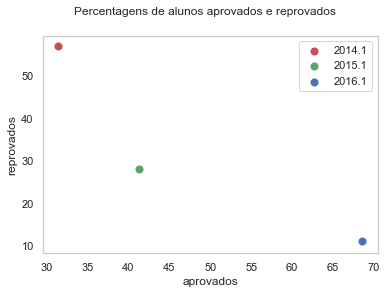

In [21]:
%matplotlib inline
fig, ax = plt.subplots()
font_size = 12
fig.suptitle('Percentagens de alunos aprovados e reprovados', fontsize=font_size)
ax.set_xlabel('aprovados', fontsize = font_size)
ax.set_ylabel('reprovados', fontsize = font_size)
colors = ['r', 'g', 'b']
for periodo, color in zip(PERIODOS, colors):
    linhas_para_plotar = df_situacoes['periodo'] == periodo
    ax.scatter(df_situacoes.loc[linhas_para_plotar, 'aprovados']
               , df_situacoes.loc[linhas_para_plotar, 'reprovados']
               , c = color
               , s = 50)
ax.legend(PERIODOS)
ax.grid()